### 7. Детектирование объектов<br>

1. Сделайте краткий обзор любой научной работы, посвящённой алгоритму для object detection, не рассматривавшемуся на уроке. Проведите анализ: чем отличается выбранная вами архитектура нейронной сети от других? В чём плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении этой архитектуры на практике?<br>

2. Ссылка на репозиторий с полным кодом для обучения ssd нейросети:https://www.kaggle.com/brendan45774/chess-piece-dectection. Попробуйте улучшить точность её работы и напишите отчёт (что вы пробовали изменить в её параметрах и как это отражалось на процессе обучения нейронной сети)

До появления сети YOLO большинство способов обнаружения объектов пытались адаптировать классификаторы для детекции. В YOLO же, обнаружение объектов было сформулировано как задача регрессии на пространственно разделенных ограничивающих рамок (bounding boxes) и связанных с ними вероятностей классов. Она позволяет добиться обнаружения объектов в режиме реального времени.<br>

В YOLO используется метод деления картинки на сетку с ячейками, каждая ячейка прогнозирует доверительное значение (confidence value) для каждой области, ограниченной bounding box’ом. Помимо этого ячейка отвечает за предсказание вероятностей классов. <Br>

Таким образом каждая ячейка предсказывает 4 координаты и вероятность принадлежности к определенному классу. За один проход мы можем пройти от входного изображения к выходному тензору, который соответствует обнаруженным объектам на картинке. Здесь нужно находить пороговое значение, чтобы избежать прогнозов с низким доверительным значением.<Br>
Далее надо искать метрику  IoU (Intersection over Union), которая покажет область пересечения ячеек. И применяется non-maximum-suppression. Подавление не-максимумов заключается в следующем: алгоритм берёт bounding box с наибольшей вероятностью принадлежности к объекту, затем, среди остальных граничащих bounding box'ов с данной области, возьмёт один с наивысшим IoU и подавляет его. Эта модель будет работать почти также быстро, как и классификация, находя за один прогон объекты, которые вероятнее всего могут находиться рядом.   
    


In [2]:
!pip install yolov3-tf

Defaulting to user installation because normal site-packages is not writeable


In [3]:

import cv2
import numpy as np 
import tensorflow as tf 

from absl import logging
from itertools import repeat
from PIL import Image
from matplotlib import pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU
from tensorflow.keras.layers import MaxPool2D, UpSampling2D, ZeroPadding2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.losses import sparse_categorical_crossentropy


In [4]:
print(tf.__version__)

2.12.0


In [5]:
yolo_iou_threshold = 0.6 # Intersection Over Union (iou) threshold.
yolo_score_threshold = 0.6 # Score threshold.

weightyolov3 = 'yolov3.weights' # Путь до файла с весами.
size = 416 # Размер изображения. 
checkpoints = 'checkpoints/yolov3.tf' # Путь до файла с checkpoint'ом.
num_classes = 80 # Количество классов в модели.

Список слоев в полностью сверточной сети YOLOv3 (FCN)

In [6]:
YOLO_V3_LAYERS = [
    'yolo_darknet',
    'yolo_conv_0',
    'yolo_output_0',
    'yolo_conv_1',
    'yolo_output_1',
    'yolo_conv_2',
    'yolo_output_2'
]

In [7]:
# Функция загрузки весов из предварительно обученной модели

def load_darknet_weights(model, weights_file):
    wf = open(weights_file, 'rb')
    major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)
    layers = YOLO_V3_LAYERS

    for layer_name in layers:
        sub_model = model.get_layer(layer_name)
        for i, layer in enumerate(sub_model.layers):
            if not layer.name.startswith('conv2d'):
                continue
            batch_norm = None
            if i + 1 < len(sub_model.layers) and \
                sub_model.layers[i + 1].name.startswith('batch_norm'):
                    batch_norm = sub_model.layers[i + 1]

            logging.info("{}/{} {}".format(
                sub_model.name, layer.name, 'bn' if batch_norm else 'bias'))
            
            filters = layer.filters
            size = layer.kernel_size[0]
            in_dim = layer.input_shape[-1]

            if batch_norm is None:
                conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)
            else:
                bn_weights = np.fromfile(wf, dtype=np.float32, count=4*filters)
                bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]

            conv_shape = (filters, in_dim, size, size)
            conv_weights = np.fromfile(wf, dtype=np.float32, count=np.product(conv_shape))
            conv_weights = conv_weights.reshape(conv_shape).transpose([2, 3, 1, 0])

            if batch_norm is None:
                layer.set_weights([conv_weights, conv_bias])
            else:
                layer.set_weights([conv_weights])
                batch_norm.set_weights(bn_weights)

    assert len(wf.read()) == 0, 'failed to read weights'
    wf.close()

In [8]:
# Функция для расчета IoU

def interval_overlap(interval_1, interval_2):
    x1, x2 = interval_1
    x3, x4 = interval_2
    if x3 < x1:
        return 0 if x4 < x1 else (min(x2,x4) - x1)
    else:
        return 0 if x2 < x3 else (min(x2,x4) - x3)

def intersectionOverUnion(box1, box2):
    intersect_w = interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect_area = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin

    union_area = w1*h1 + w2*h2 - intersect_area
    return float(intersect_area) / union_area

In [9]:
#Функция для рисования ограничивающих рамок, имен классов, вероятности и объектов, которые мы хотим обнаружить.

def draw_outputs(img, outputs, class_names, white_list=None):
    boxes, score, classes, nums = outputs
    boxes, score, classes, nums = boxes[0], score[0], classes[0], nums[0]
    wh = np.flip(img.shape[0:2])
    for i in range(nums):
        if white_list is not None and class_names[int(classes[i])] not in white_list:
            continue
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
        img = cv2.putText(img, '{} {:.4f}'.format(
            class_names[int(classes[i])], score[i]),
            x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)
    return img

In [10]:
#Функция нормализации выходных данных для ускорения обучения

class BatchNormalization(tf.keras.layers.BatchNormalization):
    def call(self, x, training=False):
        if training is None: training = tf.constant(False)
        training = tf.logical_and(training, self.trainable)
        return super().call(x, training)

    #Определяем 3 anchor box'а для каждой ячейки. 
yolo_anchors = np.array([(10, 13), (16, 30), (33, 23), (30, 61), (62, 45),
                        (59, 119), (116, 90), (156, 198), (373, 326)], np.float32) / 416
yolo_anchor_masks = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])

В каждом масштабе мы определяем 3 anchor box'а для каждой ячейки. В нашем случае если маска будет:

0, 1, 2 – означает, что будут использованы первые три якорные рамки

3, 4 ,5 – означает, что будут использованы четвертая, пятая и шестая

6, 7, 8 – означает, что будут использованы седьмая, восьмая, девятая

Создавая модель, мы строим ее с помощью функционального API, который будет легко использовать. С его помощью мы можем без труда определить ветви в нашей архитектуре (ResNet Block) и делить слои внутри архитектуры.

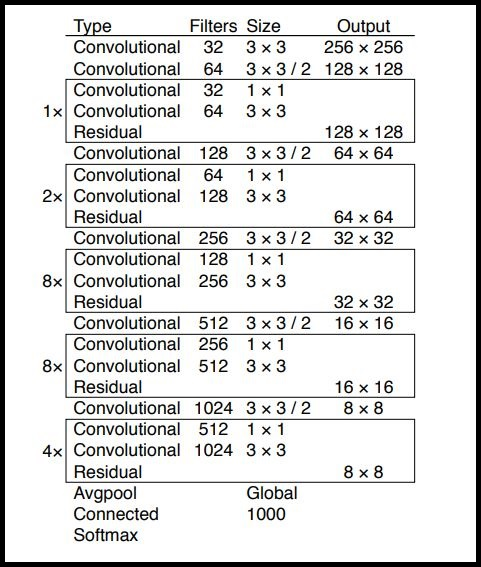

Идея заключается в том, чтобы использовать только сверточные слои. Так как их здесь 53, то самым простым способом является создание функции, в которую мы будем передавать важные параметры, меняющиеся от слоя к слою.

In [11]:
#Создание пользовательских слоев и моделей

def DarknetConv(x, filters, size, strides=1, batch_norm=True):
    if strides == 1:
        padding = 'same'
    else:
        x = ZeroPadding2D(((1, 0), (1, 0)))(x)  # top left half-padding
        padding = 'valid'
    x = Conv2D(filters=filters, kernel_size=size,
              strides=strides, padding=padding,
              use_bias=not batch_norm, kernel_regularizer=l2(0.0005))(x)
    if batch_norm:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
    return x

def DarknetResidual(x, filters):
    previous  = x
    x = DarknetConv(x, filters // 2, 1)
    x = DarknetConv(x, filters, 3)
    x = Add()([previous , x])
    return x


def DarknetBlock(x, filters, blocks):
    x = DarknetConv(x, filters, 3, strides=2)
    for _ in repeat(None, blocks):
        x = DarknetResidual(x, filters)       
    return x


def Darknet(name=None):
    x = inputs = Input([None, None, 3])
    x = DarknetConv(x, 32, 3)
    x = DarknetBlock(x, 64, 1)
    x = DarknetBlock(x, 128, 2)
    x = x_36 = DarknetBlock(x, 256, 8)
    x = x_61 = DarknetBlock(x, 512, 8)
    x = DarknetBlock(x, 1024, 4)
    return tf.keras.Model(inputs, (x_36, x_61, x), name=name)

In [12]:
def YoloConv(filters, name=None):
    def yolo_conv(x_in):
        if isinstance(x_in, tuple):
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            x, x_skip = inputs

            x = DarknetConv(x, filters, 1)
            x = UpSampling2D(2)(x)
            x = Concatenate()([x, x_skip])
        else:
            x = inputs = Input(x_in.shape[1:])

        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        return Model(inputs, x, name=name)(x_in)
    return yolo_conv

In [13]:
def YoloOutput(filters, anchors, classes, name=None):
    def yolo_output(x_in):
        x = inputs = Input(x_in.shape[1:])
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, anchors * (classes + 5), 1, batch_norm=False)
        x = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2],
                                        anchors, classes + 5)))(x)
        return tf.keras.Model(inputs, x, name=name)(x_in)
    return yolo_output


def yolo_boxes(pred, anchors, classes):
    grid_size = tf.shape(pred)[1]
    box_xy, box_wh, score, class_probs = tf.split(pred, (2, 2, 1, classes), axis=-1)

    box_xy = tf.sigmoid(box_xy)
    score = tf.sigmoid(score)
    class_probs = tf.sigmoid(class_probs)
    pred_box = tf.concat((box_xy, box_wh), axis=-1)

    grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)

    box_xy = (box_xy + tf.cast(grid, tf.float32)) /  tf.cast(grid_size, tf.float32)
    box_wh = tf.exp(box_wh) * anchors

    box_x1y1 = box_xy - box_wh / 2
    box_x2y2 = box_xy + box_wh / 2
    bbox = tf.concat([box_x1y1, box_x2y2], axis=-1)
    
    return bbox, score, class_probs, pred_box

In [14]:
# Теперь определим функцию подавления не-максимумов.

def nonMaximumSuppression(outputs, anchors, masks, classes):
    boxes, conf, out_type = [], [], []

    for output in outputs:
        boxes.append(tf.reshape(output[0], (tf.shape(output[0])[0], -1, tf.shape(output[0])[-1])))
        conf.append(tf.reshape(output[1], (tf.shape(output[1])[0], -1, tf.shape(output[1])[-1])))
        out_type.append(tf.reshape(output[2], (tf.shape(output[2])[0], -1, tf.shape(output[2])[-1])))

    bbox = tf.concat(boxes, axis=1)
    confidence = tf.concat(conf, axis=1)
    class_probs = tf.concat(out_type, axis=1)

    scores = confidence * class_probs
  
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
        scores=tf.reshape(
            scores, (tf.shape(scores)[0], -1, tf.shape(scores)[-1])),
        max_output_size_per_class=100,
        max_total_size=100,
        iou_threshold=yolo_iou_threshold,
        score_threshold=yolo_score_threshold)
  
    return boxes, scores, classes, valid_detections

In [15]:
# Основная функция

def YoloV3(size=None, channels=3, anchors=yolo_anchors,
            masks=yolo_anchor_masks, classes=80, training=False):
    x = inputs = Input([size, size, channels])

    x_36, x_61, x = Darknet(name='yolo_darknet')(x)

    x = YoloConv(512, name='yolo_conv_0')(x)
    output_0 = YoloOutput(512, len(masks[0]), classes, name='yolo_output_0')(x)

    x = YoloConv(256, name='yolo_conv_1')((x, x_61))
    output_1 = YoloOutput(256, len(masks[1]), classes, name='yolo_output_1')(x)

    x = YoloConv(128, name='yolo_conv_2')((x, x_36))
    output_2 = YoloOutput(128, len(masks[2]), classes, name='yolo_output_2')(x)

    if training:
        return Model(inputs, (output_0, output_1, output_2), name='yolov3')

    boxes_0 = Lambda(lambda x: yolo_boxes(x, anchors[masks[0]], classes),
                  name='yolo_boxes_0')(output_0)
    boxes_1 = Lambda(lambda x: yolo_boxes(x, anchors[masks[1]], classes),
                  name='yolo_boxes_1')(output_1)
    boxes_2 = Lambda(lambda x: yolo_boxes(x, anchors[masks[2]], classes),
                  name='yolo_boxes_2')(output_2)

    outputs = Lambda(lambda x: nonMaximumSuppression(x, anchors, masks, classes),
                  name='nonMaximumSuppression')((boxes_0[:3], boxes_1[:3], boxes_2[:3]))

    return Model(inputs, outputs, name='yolov3')

In [16]:
# Функция потерь

def YoloLoss(anchors, classes=80, ignore_thresh=0.5):
    def yolo_loss(y_true, y_pred):
        pred_box, pred_obj, pred_class, pred_xywh = yolo_boxes(
            y_pred, anchors, classes)
        pred_xy = pred_xywh[..., 0:2]
        pred_wh = pred_xywh[..., 2:4]

        true_box, true_obj, true_class_idx = tf.split(
            y_true, (4, 1, 1), axis=-1)
        true_xy = (true_box[..., 0:2] + true_box[..., 2:4]) / 2
        true_wh = true_box[..., 2:4] - true_box[..., 0:2]

        box_loss_scale = 2 - true_wh[..., 0] * true_wh[..., 1]

        grid_size = tf.shape(y_true)[1]
        grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
        grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
        true_xy = true_xy * tf.cast(grid_size, tf.float32) - \
            tf.cast(grid, tf.float32)
        true_wh = tf.math.log(true_wh / anchors)
        true_wh = tf.where(tf.math.is_inf(true_wh),
                      tf.zeros_like(true_wh), true_wh)

        obj_mask = tf.squeeze(true_obj, -1)
        # ignore when Intersection Over Union is over threshold
        true_box_flat = tf.boolean_mask(true_box, tf.cast(obj_mask, tf.bool))
        best_iou = tf.reduce_max(intersectionOverUnion(
            pred_box, true_box_flat), axis=-1)
        ignore_mask = tf.cast(best_iou < ignore_thresh, tf.float32)

        xy_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_xy - pred_xy), axis=-1)
        wh_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_wh - pred_wh), axis=-1)
        obj_loss = binary_crossentropy(true_obj, pred_obj)
        obj_loss = obj_mask * obj_loss + \
            (1 - obj_mask) * ignore_mask * obj_loss

        class_loss = obj_mask * sparse_categorical_crossentropy(
            true_class_idx, pred_class)

        xy_loss = tf.reduce_sum(xy_loss, axis=(1, 2, 3))
        wh_loss = tf.reduce_sum(wh_loss, axis=(1, 2, 3))
        obj_loss = tf.reduce_sum(obj_loss, axis=(1, 2, 3))
        class_loss = tf.reduce_sum(class_loss, axis=(1, 2, 3))

        return xy_loss + wh_loss + obj_loss + class_loss
    return yolo_loss

In [17]:
# Функция преобразования целей выводит кортеж формы,
# где N – число меток в пакете, а число 6 означает [x, y, w, h, obj, class] bounding box'а.

@tf.function
def transform_targets_for_output(y_true, grid_size, anchor_idxs, classes):

    N = tf.shape(y_true)[0]

    y_true_out = tf.zeros(
      (N, grid_size, grid_size, tf.shape(anchor_idxs)[0], 6))

    anchor_idxs = tf.cast(anchor_idxs, tf.int32)

    indexes = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)
    idx = 0
    for i in tf.range(N):
        for j in tf.range(tf.shape(y_true)[1]):
            if tf.equal(y_true[i][j][2], 0):
                continue
            anchor_eq = tf.equal(
                anchor_idxs, tf.cast(y_true[i][j][5], tf.int32))

            if tf.reduce_any(anchor_eq):
                box = y_true[i][j][0:4]
                box_xy = (y_true[i][j][0:2] + y_true[i][j][2:4]) / 2

                anchor_idx = tf.cast(tf.where(anchor_eq), tf.int32)
                grid_xy = tf.cast(box_xy // (1/grid_size), tf.int32)

                indexes = indexes.write(
                    idx, [i, grid_xy[1], grid_xy[0], anchor_idx[0][0]])
                updates = updates.write(
                    idx, [box[0], box[1], box[2], box[3], 1, y_true[i][j][4]])
                idx += 1

    return tf.tensor_scatter_nd_update(
        y_true_out, indexes.stack(), updates.stack())


def transform_targets(y_train, anchors, anchor_masks, classes):
    outputs = []
    grid_size = 13

    anchors = tf.cast(anchors, tf.float32)
    anchor_area = anchors[..., 0] * anchors[..., 1]
    box_wh = y_train[..., 2:4] - y_train[..., 0:2]
    box_wh = tf.tile(tf.expand_dims(box_wh, -2),
                    (1, 1, tf.shape(anchors)[0], 1))
    box_area = box_wh[..., 0] * box_wh[..., 1]
    intersection = tf.minimum(box_wh[..., 0], anchors[..., 0]) * \
    tf.minimum(box_wh[..., 1], anchors[..., 1])
    iou = intersection / (box_area + anchor_area - intersection)
    anchor_idx = tf.cast(tf.argmax(iou, axis=-1), tf.float32)
    anchor_idx = tf.expand_dims(anchor_idx, axis=-1)

    y_train = tf.concat([y_train, anchor_idx], axis=-1)

    for anchor_idxs in anchor_masks:
        outputs.append(transform_targets_for_output(
            y_train, grid_size, anchor_idxs, classes))
        grid_size *= 2

    return tuple(outputs) # [x, y, w, h, obj, class]


def preprocess_image(x_train, size):
    return (tf.image.resize(x_train, (size, size))) / 255

In [18]:
# Создание модели, загрузка весов и имен классов

yolo = YoloV3(classes=num_classes)

load_darknet_weights(yolo, weightyolov3)

#yolo.save_weights(checkpoints)

class_names =  ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl",
    "banana","apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut",
    "cake","chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop",
    "mouse","remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink",
    "refrigerator","book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

Чтобы протестировать получившийся алгоритм обнаружения объектов, загрузим изображение с компьютера.
 Можно использовать и другие методы, например
 скачать из интернета или гугл диска

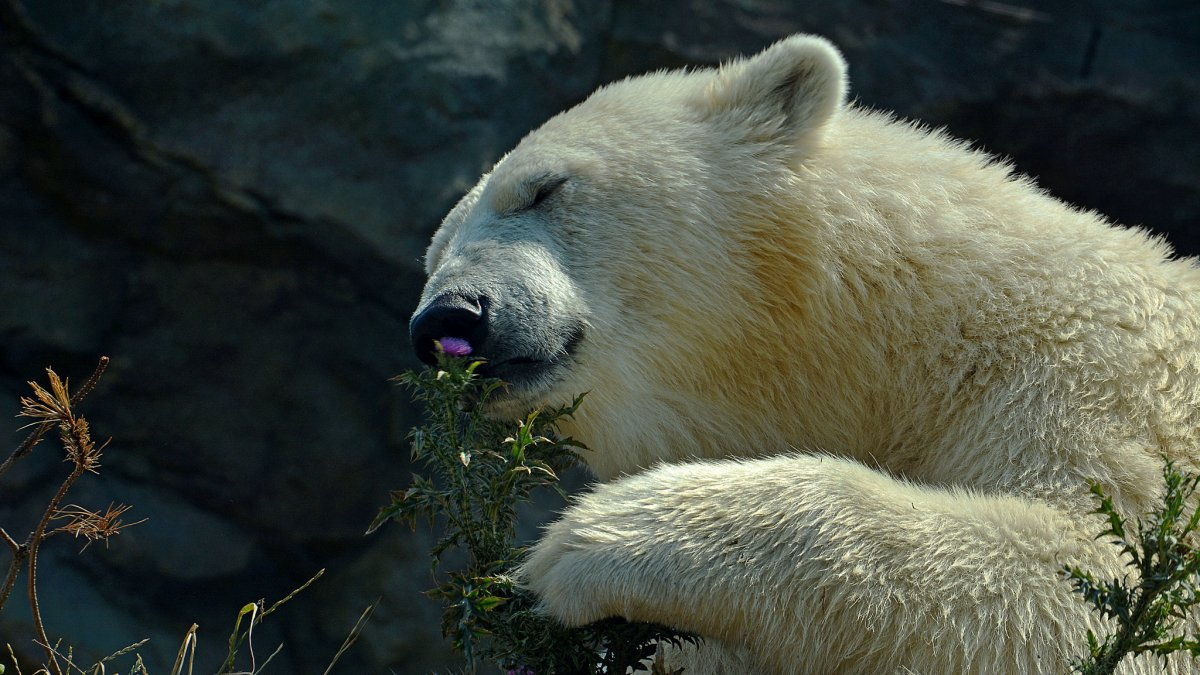

In [19]:
from PIL import Image
Image.open('topics-01.jpg')


Найдем объект: "Медведь"

In [20]:
def detect_objects(img_path, white_list):
    image = img_path 

    img = tf.image.decode_image(open(image, 'rb').read(), channels=3)
    img = tf.expand_dims(img, 0)
    img = preprocess_image(img, size)

    boxes, scores, classes, nums = yolo(img)

    img = cv2.imread(image)
    img = draw_outputs(img, (boxes, scores, classes, nums), class_names, white_list)

    cv2.imwrite('detected_{:}'.format(img_path), img)

    detected = Image.open('detected_{:}'.format(img_path))
    detected.show()
    plt.title('Detected image')
    plt.imshow(detected)
    


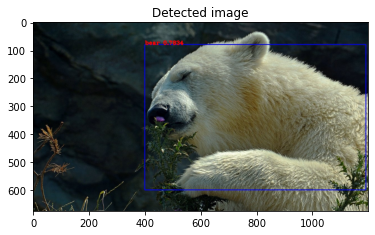

In [21]:
detect_objects('topics-01.jpg', ['bear'])


С высокой точностью (78%) определяется искомый объект. Попробуем снова на другой картинке

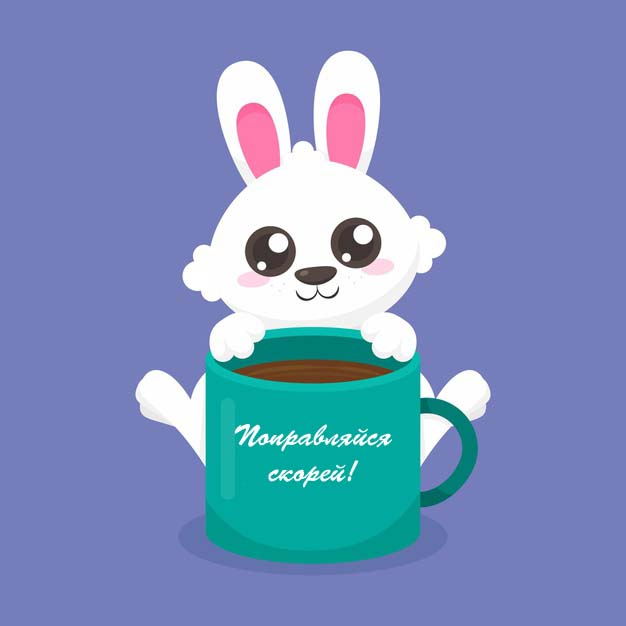

In [22]:
Image.open('buny-cap.jpg')

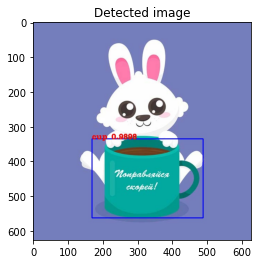

In [23]:
detect_objects('buny-cap.jpg',['cup'])

Точность 98%

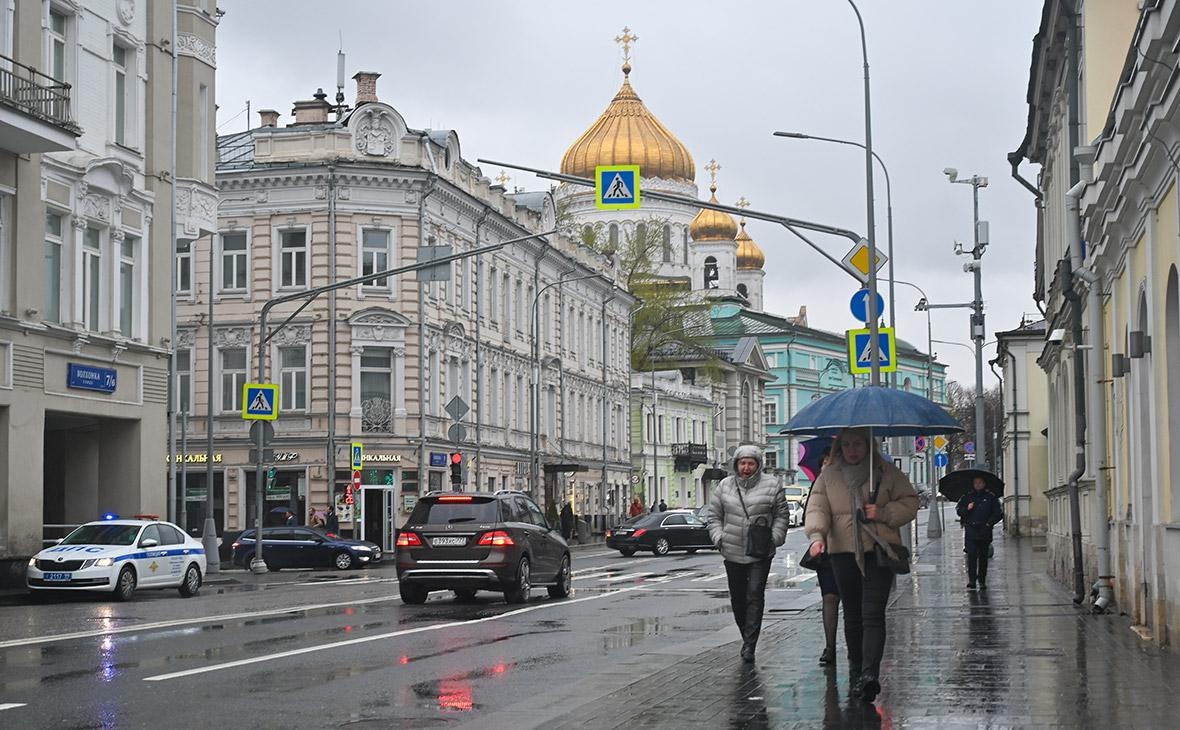

In [24]:
Image.open('street01.jpg')

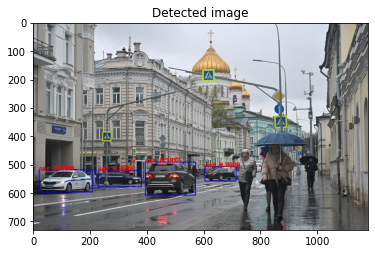

In [25]:
detect_objects('street01.jpg',['car'])

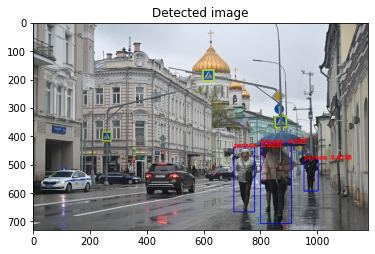

In [26]:
detect_objects('street01.jpg',['person'])